# Essai SHAP

In [1]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap

shap.initjs()


In [2]:
corpus,y = shap.datasets.imdb()
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)


In [3]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [4]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


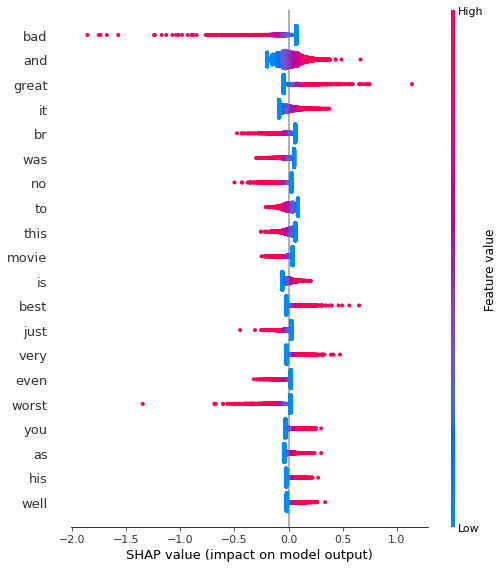

In [7]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

In [8]:


ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)



In [9]:


print("Positive" if y_test[ind] else "Negative", "Review:")
print(corpus_test[ind])



Positive Review:
"Twelve Monkeys" is odd and disturbing, yet being so clever and intelligent at the same time. It cleverly jumps between future and the past, and the story it tells is about a man named James Cole, a convict, who is sent back to the past to gather information about a man-made virus that wiped out 5 billion of the human population on the planet back in 1996. At first Cole is sent back to the year 1990 by accident and by misfortune he is taken to a mental institution where he tries to explain his purpose and where he meets a psychiatrist Dr. Kathryn Railly who tries to help him and a patient named Jeffrey Goines, the insane son of a famous scientist. Being provocative and somehow so sensible, dealing with and between reason and madness, the movie is a definite masterpiece in the history of science-fiction films.<br /><br />The story is just fantastic. It's so original and so entertaining. The screenplay itself written by David and Janet Peoples is inspired by a movie name

In [14]:
y_train[0:5]

array([False,  True, False,  True, False])

In [15]:
shap.plots.bar(shap_values[:,:,True].mean(0))

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

In [17]:
shap_values[0:5]

array([[1.45539054e-05, 3.02678566e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.45539054e-05, 3.02678566e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.45539054e-05, 3.02678566e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.45539054e-05, 3.02678566e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.45539054e-05, 3.02678566e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [18]:
shap_values.shape

(5000, 16416)

## Essai 2

source : https://shap.readthedocs.io/en/stable/example_notebooks/text_examples/sentiment_analysis/Emotion%20Classification%20Explanation%20Demo.html

In [21]:
!pip install --upgrade pip

In [2]:
!pip install datasets

     |████████████████████████████████| 234 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 19.3 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 14.1 MB/s eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.56.2
    Uninstalling tqdm-4.56.2:
      Successfully uninstalled tqdm-4.56.2


In [3]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import shap
import scipy as sp
from datasets import load_dataset
import torch

In [6]:
dataset  = load_dataset("emotion", split = "train")
data = pd.DataFrame({'text':dataset['text'],'emotion':dataset['label']})

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681. Subsequent calls will reuse this data.


In [7]:
data.head()

,text,emotion
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion",use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

In [5]:
!nvidia-smi

Sat May 29 09:38:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 960M    On   | 00000000:01:00.0 Off |                  N/A |
| N/A   63C    P0    N/A /  N/A |   1856MiB /  2002MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# set mapping between label and id
id2label = model.config.id2label
label2id = model.config.label2id
labels = sorted(label2id, key=label2id.get)

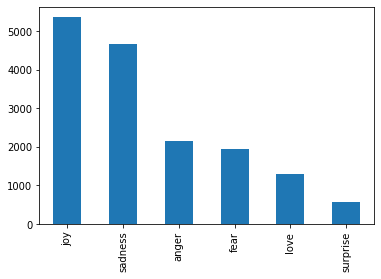

In [9]:
ax = data.emotion.map(id2label).value_counts().plot.bar()

In [10]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [11]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

explainers.Partition is still in an alpha state, so use with caution...


In [13]:
!nvidia-smi

Sat May 29 09:49:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 960M    On   | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0    N/A /  N/A |   1809MiB /  2002MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
!nvidia-smi

Sat May 29 09:51:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 960M    On   | 00000000:01:00.0 Off |                  N/A |
| N/A   63C    P0    N/A /  N/A |   1907MiB /  2002MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
with torch.no_grad():
    shap_values = explainer(data['text'][0:50])

Partition explainer: 51it [01:10,  1.60s/it]                        


In [27]:
from wordcloud import WordCloud

In [29]:
wc = WordCloud(
                      max_font_size=200,
                      width=2500,
                      height=2000,
                      max_words=4000,
                      random_state=44,
                     ).generate(X_train['text'][y_train['sentiment']=='positive'])

IndexError: Index dimension must be <= 2

In [31]:
X_train['text'][y_train['sentiment']=='positive']

IndexError: Index dimension must be <= 2

In [33]:
y_train

array([False,  True, False, ..., False, False,  True])